<a href="https://colab.research.google.com/github/aghakishiyeva/Explainable-Techniques/blob/main/AIPI590_Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in? Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/aghakishiyeva/Explainable-Techniques/tree/main)

### Installing and Importing Necessary Libraries

In this step, we install and import the necessary libraries: torch and torchvision for loading the pre-trained ResNet34 model and handling image transformations, lime for generating explanations, and matplotlib for visualizations. We also import skimage for image segmentation used in LIME's output. Additionally, we download and load ImageNet class labels using json, allowing us to map the model’s predicted class indices to human-readable labels (e.g., "rabbit") for better interpretation of the predictions.

In [3]:
# !pip install torch torchvision lime matplotlib
import torch
import torchvision.models as models
from torchvision import datasets, transforms
from torchvision import transforms
from PIL import Image
from lime import lime_image
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Download ImageNet labels
!wget -q https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

# Load the labels
import json
with open('imagenet-simple-labels.json') as f:
    labels = json.load(f)

### Loading the Image

In this step, we load the image that was uploaded using the PIL (Python Imaging Library).

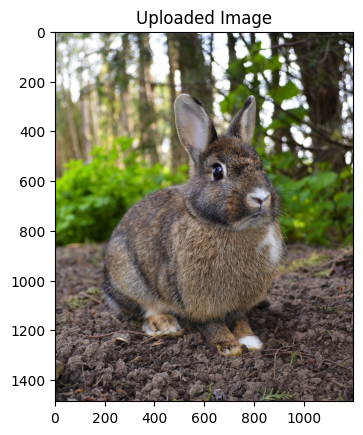

In [6]:
# Load the uploaded image
image_path = "/content/Rabbit.jpg"
img = Image.open(image_path)

# Display the image
plt.imshow(img)
plt.title("Uploaded Image")
plt.show()

### Preprocessing the Image for ResNet34

 In this step, we define a preprocessing pipeline for the image to make it compatible with the ResNet34 model, which expects images to be of size 224x224 pixels.

In [12]:
# Preprocessing transformation (resize and normalize)
preprocess = transforms.Compose([
    transforms.Resize(224),  # ResNet34 expects images to be 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply preprocessing
img_t = preprocess(img)
img_t = img_t.unsqueeze(0)  # Add batch dimension

### Loading the Pre-trained ResNet34 Model

Here, we load a pre-trained ResNet34 model from torchvision, which has been trained on the ImageNet dataset. By setting model.eval(), we ensure the model is in evaluation mode, meaning that layers like dropout or batch normalization behave consistently during inference (and not as they would during training).

In [8]:
# Load a pre-trained ResNet34 model
model = models.resnet34(pretrained=True)
model.eval()  # Set the model to evaluation mode

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 36.9MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Defining the Prediction Function

In this cell, we define the predict function for LIME. This function takes the preprocessed image batch, passes it through the ResNet34 model, and returns the softmax probabilities for each class. The softmax output represents the probability distribution over the possible classes.

In [13]:
# Define a prediction function for LIME
def predict(img_batch):
    # Convert the NumPy image batch back to a torch tensor
    img_batch = torch.tensor(img_batch).permute(0, 3, 1, 2).float()  # Rearrange dimensions (H, W, C) -> (B, C, H, W)
    with torch.no_grad():  # No gradient calculation needed
        logits = model(img_batch)  # Pass the tensor batch through the model
    return logits.softmax(dim=1).cpu().numpy()  # Return softmax probabilities as NumPy array


### Generating the LIME Explanation

Here, we initialize the LIME image explainer for image data and generate an explanation for the model's top prediction using the explain_instance function. We convert the preprocessed image back into a NumPy array format because LIME requires a NumPy array as input.

In [14]:
# Initialize the LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Convert the image tensor to a NumPy array for LIME (required format)
# We are denormalizing the image because LIME expects values between [0, 255]
img_numpy = img_t.squeeze(0).permute(1, 2, 0).numpy()  # Convert (B, C, H, W) -> (H, W, C)

# Denormalize the image back to [0, 255]
img_numpy = (img_numpy * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
img_numpy = np.clip(img_numpy, 0, 255).astype(np.uint8)  # Ensure values are within [0, 255]

# Generate an explanation for the model's prediction
explanation = explainer.explain_instance(img_numpy, predict, top_labels=1, hide_color=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Visualizing the Explanation

This code defines a function to retrieve the predicted class and its probability from the pre-trained ResNet34 model. Using get_predicted_class, it passes the preprocessed image through the model, applies softmax to obtain probabilities, and retrieves the top predicted class and its confidence score. The predicted class index is then mapped to a human-readable label using the ImageNet labels. Next, LIME is used to generate an explanation for the model's prediction by highlighting the most important regions of the image. The important regions are marked using mark_boundaries and displayed on the image. Finally, the image is plotted with the predicted class label and the model's confidence score in the title.

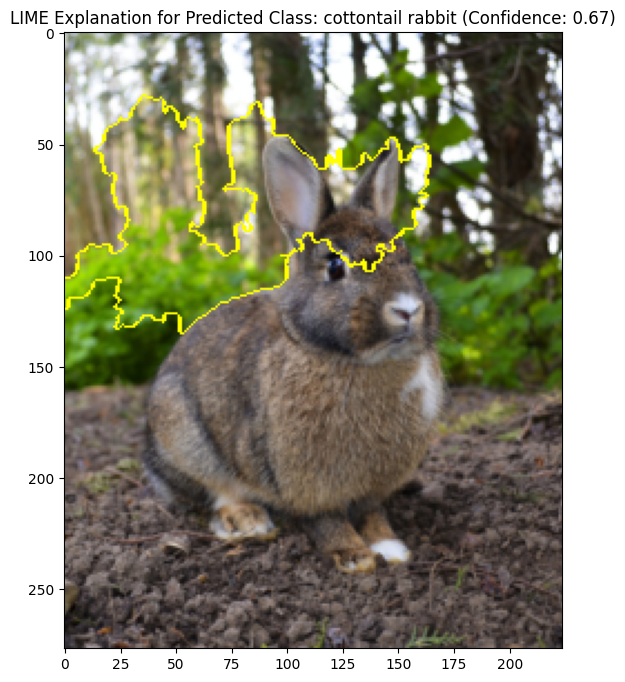

In [17]:
# Get the predicted class label
def get_predicted_class(img_tensor):
    with torch.no_grad():
        logits = model(img_tensor)
        probs = torch.softmax(logits, dim=1)
        top_prob, top_class = probs.topk(1, dim=1)
        return top_class.item(), top_prob.item()  # Return the class index and the probability

# Get the predicted class and label
pred_class_idx, pred_prob = get_predicted_class(img_t)
pred_class_label = labels[pred_class_idx]

# Update the plot with the predicted class
from skimage.segmentation import mark_boundaries

# Get explanation image and mask
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry = mark_boundaries(temp / 255.0, mask)

# Plot the result
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img_boundry)
ax.set_title(f"LIME Explanation for Predicted Class: {pred_class_label} (Confidence: {pred_prob:.2f})")
plt.show()


### Discussion on Explanation Technique: LIME

For this task, we chose **LIME** (Local Interpretable Model-agnostic Explanations) to explain the individual prediction made by the pre-trained ResNet34 model on the image of a rabbit. LIME was selected because it provides localized explanations for complex models like deep neural networks by approximating them with simpler, interpretable models in the vicinity of a given prediction. This helps us understand how specific parts of the image influenced the classification decision, in this case, a prediction of "cottontail rabbit" with a confidence score of 67%.

#### Strengths:
- **Model-Agnostic**: One of LIME's greatest strengths is that it can be used with any black-box model, including deep learning models like ResNet34.
- **Local Explanations**: LIME provides localized insights into how individual parts of the input contributed to the model’s prediction. In our example, it identified key regions of the rabbit’s face and surroundings that influenced the model's classification.
- **Intuitive Visuals**: The visual explanation of LIME highlights which parts of the image were important for the prediction, making it easy to understand even for non-experts.

#### Limitations:
- **Approximation**: LIME uses a linear model to approximate complex models locally, which may not always perfectly capture the behavior of a highly non-linear model like ResNet34. Therefore, the explanation might not reflect all the intricate details of the model's decision-making process.
- **Use of Background Information**: From the generated explanation, we can see that parts of the background were also used by the model to predict "cottontail rabbit." This reliance on irrelevant parts of the image may indicate that the model is not fully focusing on the object itself, which is not ideal for accurate classification.
- **Computationally Expensive**: Since LIME works by perturbing the input and observing changes in the model’s output, it can be computationally expensive, especially for larger images or deeper models.

#### Potential Improvements:
- **Incorporating Global Explanations**: While LIME provides local explanations, it does not offer global insights into the model’s behavior. Combining LIME with techniques like SHAP (Shapley Additive Explanations), which can provide both local and global interpretations, could enhance our understanding of the model’s predictions.
- **Optimizing Perturbation**: The quality of LIME’s explanation depends on how the input is perturbed. By optimizing the perturbation strategy or tuning the number of perturbations, we could potentially obtain more accurate and faster explanations.
- **Reducing Background Influence**: Techniques such as attention mechanisms or saliency maps could be explored to reduce the model’s reliance on irrelevant background information when making predictions.

Overall, LIME successfully provided an interpretable explanation of the ResNet34 model’s decision, showing that certain regions around the rabbit's face and head were most important for predicting the class "cottontail rabbit." However, it also highlighted parts of the background, which suggests that the model may not be fully focusing on the correct features for classification.